# Applying Clustering Techniques: Customers Segmentation

Understanding your customers is crucial for any business aiming to thrive in a competitive market. Customer segmentation, the process of dividing a customer base into distinct groups, allows businesses to tailor their strategies to meet the unique needs of each segment. By identifying patterns and behaviors within customer data, businesses can make informed decisions to enhance customer experience, optimize marketing efforts, and boost overall satisfaction.

This Customer Segmentation Notebook serves as a learning tool to practise clustering methods by analyzing and categorizing customers based on various attributes.

## Loading Libraries

In [1]:
import warnings

from kneed import KneeLocator  #  conda config --add channels conda-forge
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
#warnings.filterwarnings("ignore", category=FutureWarning)

## Dataset Exploration
We are going to work with the ["Mall Customer Segmentation Data" dataset from Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data "Go to the Website").

It contains information about customers in a shopping mall and includes the following features:
 * **CustomerID:** Unique identifier for each customer.
 * **Gender:** Gender of the customer (Male or Female).
 * **Age:** Age of the customer.
 * **Annual Income:** Annual income of the customer.
 * **Spending Score:** A score assigned based on customer behavior and spending nature.

First we need to load the data to work with:

Displaying basic information about the dataset:

In [3]:
FILE_PATH = "./data/Mall_Customers.csv"
df = pd.read_csv(FILE_PATH)
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [5]:
print(df["CustomerID"].nunique() == len(df["CustomerID"]))

True


CustomerID does not carry any useful information and can be used as an identifier

In [6]:
df.set_index("CustomerID", inplace=True)
df.Gender = df.Gender.astype('category')

Thus, we have one categorical column and three numerical ones. There are also no missing values we should worry about (otherwise we would need to deal with them through dropping the column/entries or through imputation methods!)

Displaying summary statistics of the dataset:

In [7]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000


Visualisation of distribution of data using histograms:

/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

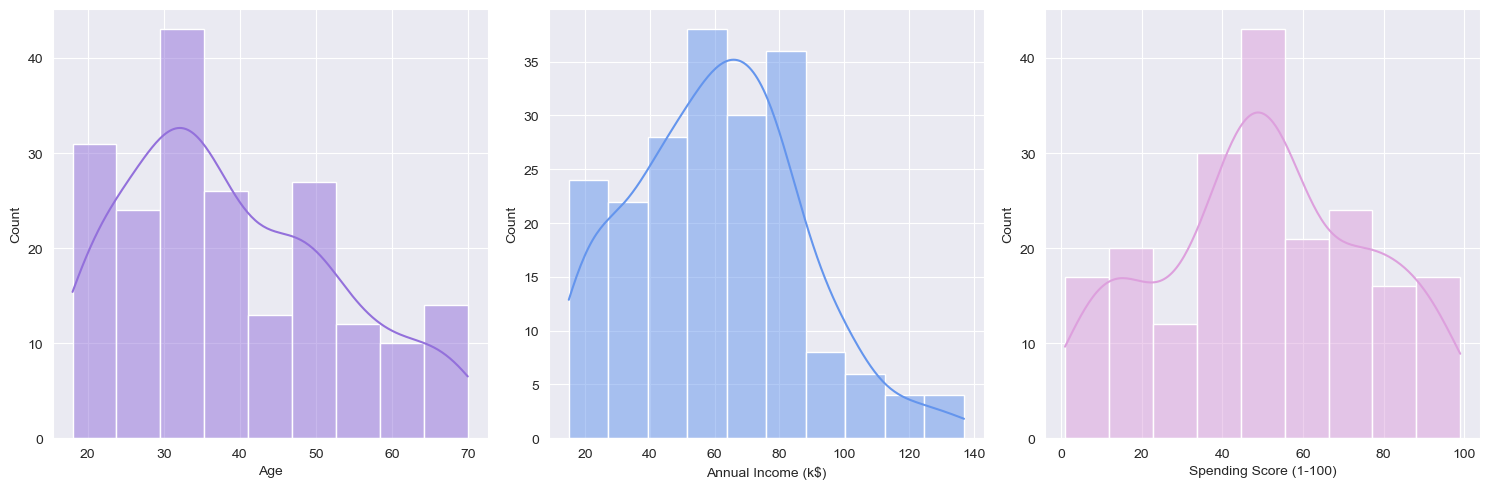

In [8]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colors = ['mediumpurple', 'cornflowerblue', 'plum', 'lightskyblue', 'paleturquoise']
numerical_cols = df.select_dtypes(include=np.number)

for i, (col, color) in enumerate(zip(numerical_cols, colors)):
    sns.histplot(df[col], kde=True, ax=axes[i], color=color)

plt.tight_layout()
plt.show()

Using a pie chart to look at the gender distribution in the dataset:

/tmp/ipykernel_318789/167087913.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Gender').size().plot(kind='pie', colors=colors, autopct='%1.0f')


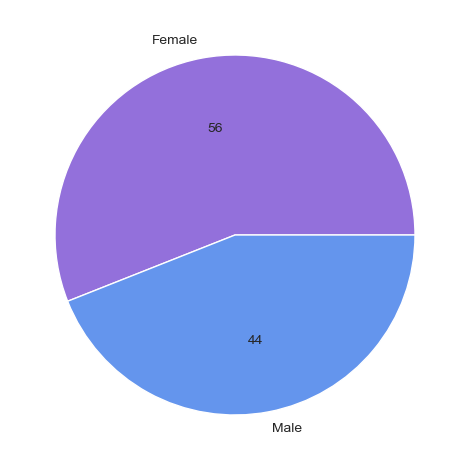

In [9]:
df.groupby('Gender').size().plot(kind='pie', colors=colors, autopct='%1.0f')
plt.tight_layout()
plt.show()

Using violin plots we can see, how the data from other columns is distributed for the customers of each gender:

/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn

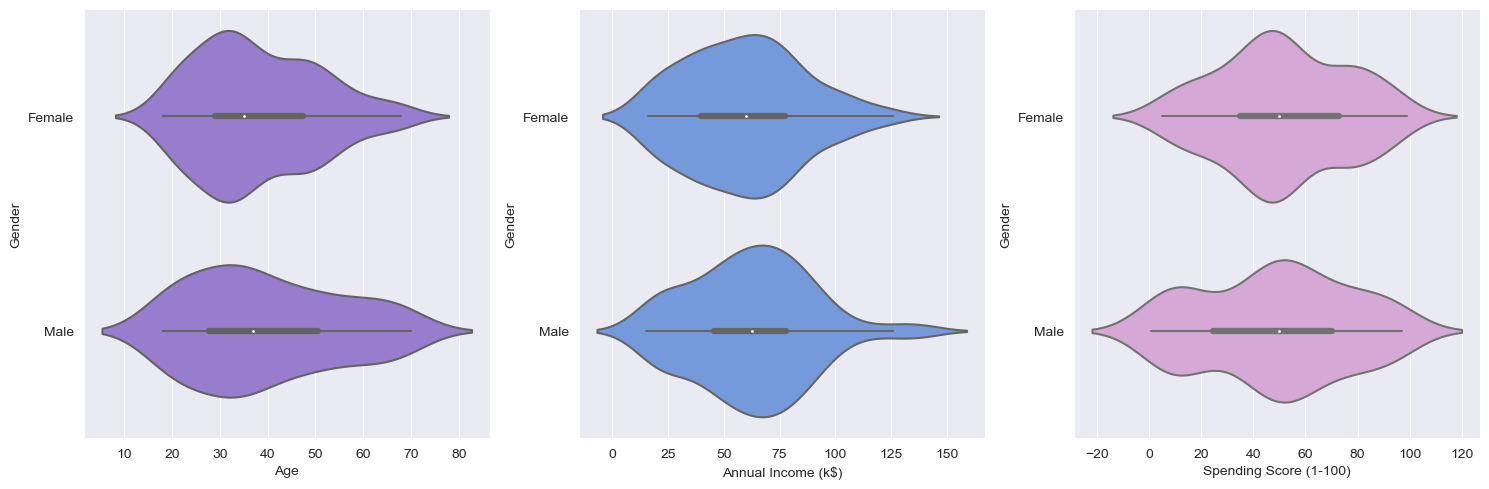

In [10]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, (col, color) in enumerate(zip(numerical_cols, colors)):
    sns.violinplot(data=df, x=col, y="Gender", kind="violin", ax=axes[i], color=color)

plt.tight_layout()
plt.show()

Using pair-plots help us see the pairwise relations between different columns:

/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amario/anaconda3/envs/Workshop/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

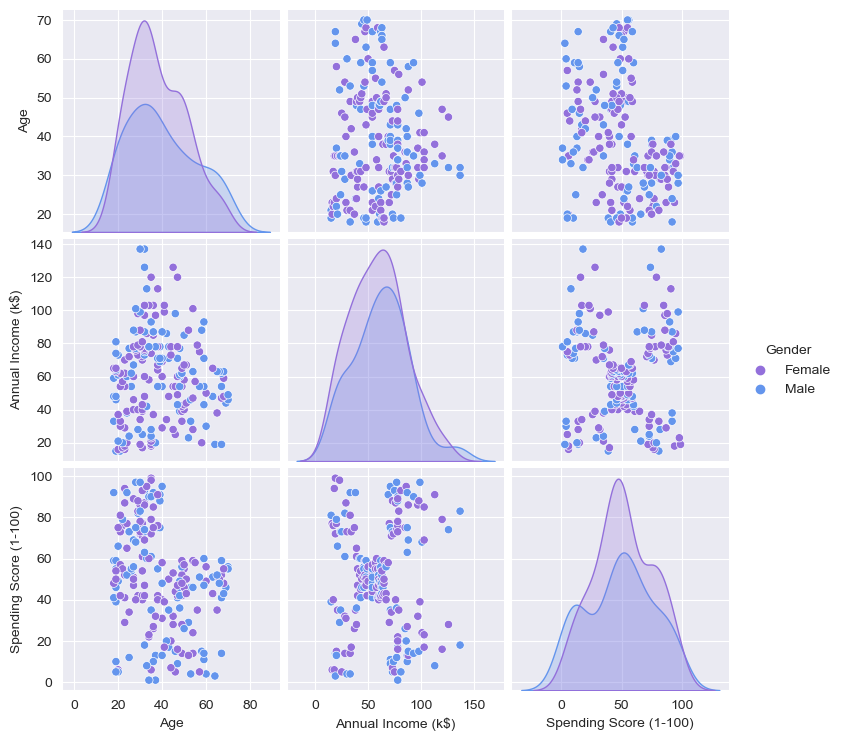

In [11]:
sns.pairplot(df, hue='Gender', palette=colors)
plt.show()

## K-Means
### Feature Engineering
At this step, we can decide, what features we would like to further work with:

In [27]:
cols_for_clustering = ['Age', 'Annual Income (k$)',
                       'Spending Score (1-100)']  #  Age / Annual Income (k$) / Spending Score (1-100)
features = df[cols_for_clustering]
features

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
...,...,...,...
196,35,120,79
197,45,126,28
198,32,126,74


Normalizing the data:

In [26]:
scaler = StandardScaler()  # StandardScaler / MinMaxScaler
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

K-Means algorithm is performed by using KMeans() function from the scikit-learn library. The following parameters can be adjusted:
* **init** - sets the initialization technique . "random" sets the standard version of k-means.
* **n_clusters** - sets _k_ (number of clusters)
* **n_init** - defines the number of initializations. An initialization with the lowest SSE will be chosen (_SEE_ - Sum of Squared Error; is defined as the sum of the squared Euclidean distances of each point to its closest centroid; determines the quality of clusters assignments)
* **max_iter** - sets the number of maximum iterations for each initialization

In [14]:
kmeans_kwargs = {
    'init': 'random',
    #'n_clusters': 3,
    'n_init': 10,
    'max_iter': 300
}

### Choosing the Number of Clusters

There are two commonly used methods for choosing the K-value (the number of clusters):
1. The **elbow method**
2. The **silhouette coefficient**

These methods are often used together to complement each other rather than using one of them preferred over the other.

In order to perform the **elbow method**, K-means is run several times, where the number of clusters increases with every iteration. The SSE values are recorded for each run to be plotted afterwards as a function of the number of clusters:

In [15]:
sse = []
k_range = 13

for k in range(1, k_range):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

When we plot SSE, we will be able to notice, that its values decreases with the increase of k. The more centroids are added, the smaller the distances from samples to their closest centroids will be.

There is a spot, where the curve will start to bend down -- **the elbow point**. After this point, the speed of decline will be noticeably reduced. The k-value at this point is a reasonable trade-off between error and number of clusters.

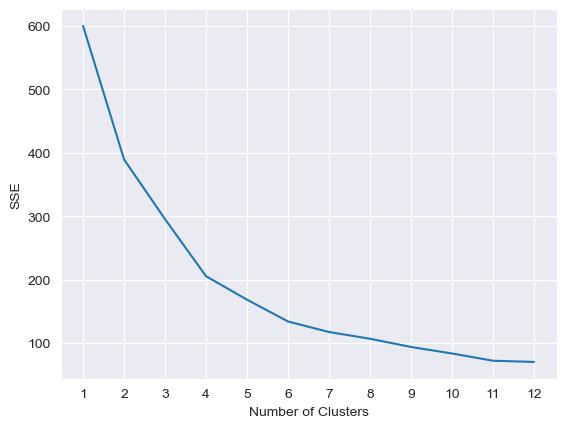

In [16]:
plt.plot(range(1, k_range), sse)
plt.xticks(range(1, k_range))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

It can sometimes be tricky to determine, where the elbow point is, just by looking at it. It is not unusual that the curve changes its decline angle multiple times, so it is hard to tell, from what moment the increase of k-value won't matter to us much anymore.

We can automate the process of choice of the elbow point by using the _KneeLocator_ function from the _kneed_ package.

In [17]:
elbow_point = KneeLocator(
    range(1, k_range), sse, curve='convex', direction='decreasing'
)

print(elbow_point.elbow)

4


The silhouette coefficient measures clusters cohesion and separation. Its values range from -1 to 1. The more this value is, the closer the samples are to their cluster than to other clusters.

To calculate the silhouette value, the _silhouette_score_ function from the _scikit-learn_ package will be used. This function calculates the sum of average silhouette coefficients of all the samples. It also needs minimum of two clusters to function properly.

The sums of silhouette coefficients are calculated for a range of k-values, as it was in case of the elbow method. These values are then plotted and the maximum score on a graph should identify the optimal number of clusters.

In [18]:
silhouette_scores = []

for k in range(2, k_range):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

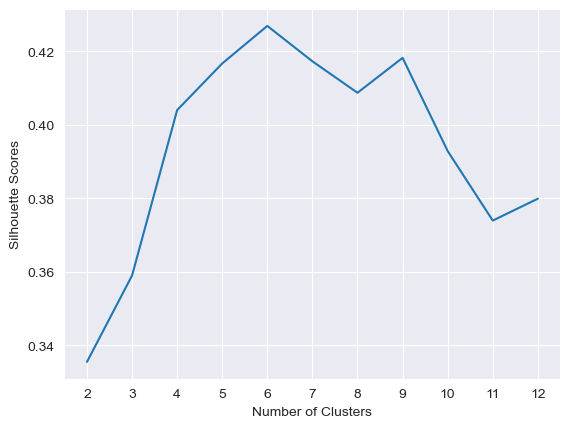

In [19]:
plt.plot(range(2, k_range), silhouette_scores)
plt.xticks(range(2, k_range))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')

plt.show()

### Performing Clustering

Performing the clustering after identifying the optimal k-value:

In [20]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
labels = kmeans.fit_predict(scaled_features)
print(labels)

[0 0 4 0 0 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4
 0 4 0 3 0 4 0 4 0 3 0 0 0 3 0 0 3 3 3 3 3 0 3 3 0 3 3 3 0 3 3 0 0 3 3 3 3
 3 0 3 3 0 3 3 0 3 3 0 3 3 0 0 3 3 0 3 3 0 0 3 0 3 0 0 3 3 0 3 0 3 3 3 3 3
 0 2 0 0 0 3 3 3 3 0 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]


Number of iterations required for converge:

In [21]:
print(kmeans.n_iter_)

8


As long as we are dealing with up to 3 feature dimensions, we can easily visualise the clusters in these dimensions.

Next, choose one of the following visualisation scripts, depending on whether you are performing K-means on 2 or 3 features.



### Plotting the results

 Plotting the clusters when using two feature dimensions:

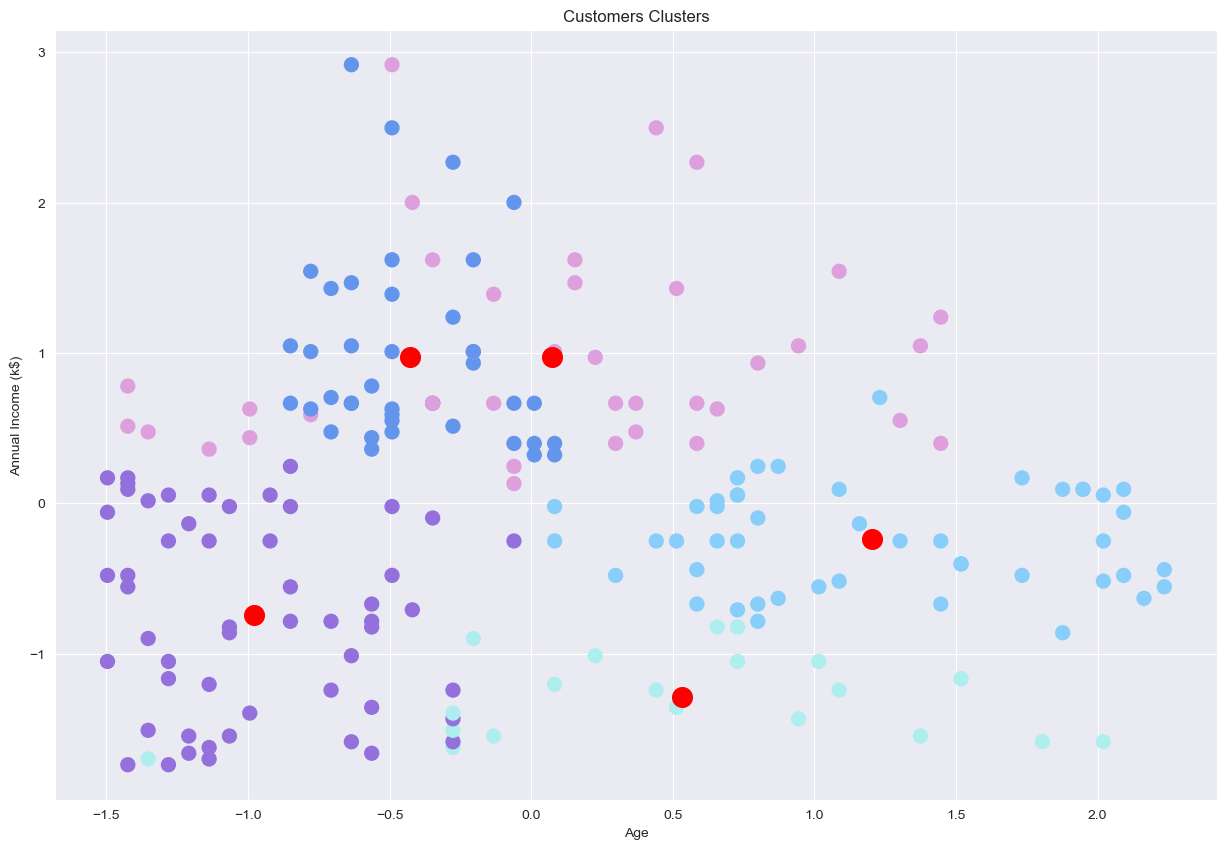

In [32]:
color_palette = sns.color_palette(colors)

plt.figure(figsize=(15, 10))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1],
            c=kmeans.labels_, s=100, cmap=ListedColormap(color_palette))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', s=200)
plt.title('Customers Clusters')
plt.xlabel(cols_for_clustering[0])
plt.ylabel(cols_for_clustering[1])
plt.show()

Plotting the clusters, when using three feature dimensions

In [29]:
features['label'] = labels
fig = px.scatter_3d(features, x=cols_for_clustering[0],
                    y=cols_for_clustering[1], z=cols_for_clustering[2],
                    color='label', size='label', color_discrete_sequence=colors)
fig.show()

<class 'numpy.ndarray'>
